In [4]:
# PASO 0: INSTALACIÓN DE TODAS LAS LIBRERÍAS (MÉTODO ROBUSTO)
# ===================================================================
import sys

# Este comando usa la ruta exacta del Python que está ejecutando tu notebook
# para asegurarse de que las librerías se instalen en el lugar correcto.
!{sys.executable} -m pip install -q torch torchvision pandas numpy scikit-learn matplotlib seaborn Pillow imbalanced-learn statsmodels gdown

print("✅ Todas las librerías necesarias han sido instaladas.")

✅ Todas las librerías necesarias han sido instaladas.


In [1]:
# ===================================================================
# PASO 0.5: IMPORTACIONES
# ===================================================================
import os
import zipfile
import time
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from itertools import combinations
import gdown

# Ahora sí, la importación funcionará
from imblearn.over_sampling import RandomOverSampler
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
from torchvision.models import (
    resnet18, ResNet18_Weights,
    mobilenet_v2, MobileNet_V2_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights
)

print("Librerías importadas con éxito.")


Librerías importadas con éxito.


In [2]:
# ===================================================================
# PASO 1: CONFIGURACIÓN
# ===================================================================

# 1. PEGA AQUÍ EL ID DE TU ARCHIVO ZIP DEL DATASET DE CLASIFICACIÓN
FILE_ID_DATASET = '1LGJKUx6nw7SegQ3J4nJxTQq8KRk6WRUL' # <--- ¡CAMBIA ESTO!

# 2. PARÁMETROS DE ENTRENAMIENTO
NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MODELS_TO_TRAIN = ['ResNet18', 'MobileNetV2', 'EfficientNetB0', 'ConvNeXt']

# 3. NOMBRES PARA LOS ARCHIVOS Y CARPETAS
DATASET_ZIP_FILENAME = 'dataset_clasificacion.zip'
EXTRACT_TO_FOLDER = './dataset_clasificacion'
RESULTS_DIR = './resultados_clasificacion'
FINAL_RESULTS_ZIP_NAME = 'resultados_finales_clasificacion.zip'
# -----------------------------------------------------------

In [3]:
# ===================================================================
# PASO 2: DESCARGA Y PREPARACIÓN DEL DATASET
# ===================================================================
try:
    print(f"\nDescargando dataset de clasificación...")
    gdown.download(id=FILE_ID_DATASET, output=DATASET_ZIP_FILENAME, quiet=False)
    print("Descomprimiendo dataset...")
    with zipfile.ZipFile(DATASET_ZIP_FILENAME, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO_FOLDER)
    os.remove(DATASET_ZIP_FILENAME)
    # Busca la carpeta principal dentro de la extracción
    ruta_base = os.path.join(EXTRACT_TO_FOLDER, os.listdir(EXTRACT_TO_FOLDER)[0])
    print(f"Dataset listo en: {ruta_base}")
except Exception as e:
    print(f"ERROR al procesar el dataset: {e}")
    raise SystemExit("Deteniendo ejecución.")


Descargando dataset de clasificación...


Downloading...
From (original): https://drive.google.com/uc?id=1LGJKUx6nw7SegQ3J4nJxTQq8KRk6WRUL
From (redirected): https://drive.google.com/uc?id=1LGJKUx6nw7SegQ3J4nJxTQq8KRk6WRUL&confirm=t&uuid=8b0a51a3-26c5-4b45-9cde-a33140267ce8
To: /Modelo de clasificacion/dataset_clasificacion.zip
100%|██████████| 279M/279M [00:07<00:00, 36.6MB/s] 


Descomprimiendo dataset...
Dataset listo en: ./dataset_clasificacion/Conjunto de datos enfermedad del pollo


In [4]:
# ===================================================================
# PASO 3: PROCESAMIENTO DE DATOS (ROS Y AUMENTO)
# ===================================================================
class BalancedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths, self.labels, self.transform = image_paths, labels, transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, self.labels[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")

data_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_transforms_val_test = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

initial_train_dataset = datasets.ImageFolder(root=os.path.join(ruta_base, 'train'), transform=data_transforms_train)
val_dataset = datasets.ImageFolder(root=os.path.join(ruta_base, 'validation'), transform=data_transforms_val_test)
test_dataset = datasets.ImageFolder(root=os.path.join(ruta_base, 'test'), transform=data_transforms_val_test)

print("\nAplicando Sobremuestreo ROS...")
image_paths = [s[0] for s in initial_train_dataset.samples]
labels = initial_train_dataset.targets
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(image_paths).reshape(-1, 1), labels)
train_dataset = BalancedDataset(image_paths=X_resampled.ravel().tolist(), labels=y_resampled, transform=data_transforms_train)
print(f"Dataset de entrenamiento balanceado con {len(train_dataset)} imágenes.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = initial_train_dataset.classes
print(f"Clases detectadas: {class_names}")


Usando dispositivo: cuda

Aplicando Sobremuestreo ROS...
Dataset de entrenamiento balanceado con 8400 imágenes.
Clases detectadas: ['Coccidiosis', 'Newcastle Disease', 'Salmonella', 'Sanas']


In [5]:
# ===================================================================
# PASO 4: ENTRENAMIENTO DE LOS MODELOS (CON SALIDA MEJORADA)
# ===================================================================
print("\n" + "="*80)
print("INICIANDO FASE DE ENTRENAMIENTO Y VALIDACIÓN")
print("="*80)

for model_name in MODELS_TO_TRAIN:
    print(f"\n--- Entrenando modelo: {model_name} ---")
    model_output_dir = os.path.join(RESULTS_DIR, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    csv_filename = os.path.join(model_output_dir, "training_log.csv")
    with open(csv_filename, 'w', newline='') as f:
        csv.writer(f).writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy", "Time (s)"])

    if model_name == 'ResNet18': model = resnet18(weights=ResNet18_Weights.DEFAULT); model.fc = nn.Linear(model.fc.in_features, len(class_names))
    elif model_name == 'MobileNetV2': model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'EfficientNetB0': model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'ConvNeXt': model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT); model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2, min_lr=1e-6)
    best_val_loss = float('inf')

    # Variable para el tiempo total, si la necesitas
    total_training_time = time.time()

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        model.train(); running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1); total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
        train_loss = running_loss/total_train; train_acc = 100*correct_train/total_train

        model.eval(); val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs); loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1); total_val += labels.size(0); correct_val += (predicted == labels).sum().item()
        val_acc = 100*correct_val/total_val; current_val_loss = val_loss/total_val

        scheduler.step(current_val_loss)
        epoch_duration = time.time() - start_time

        # --- LÍNEA DE CÓDIGO MODIFICADA ---
        print(f"  Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {current_val_loss:.4f}, Val Acc: {val_acc:.2f}% | Time: {epoch_duration:.2f}s")
        # ------------------------------------

        with open(csv_filename, 'a', newline='') as f:
            csv.writer(f).writerow([epoch+1, train_loss, train_acc, current_val_loss, val_acc, epoch_duration])
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            torch.save(model.state_dict(), os.path.join(model_output_dir, "best_model.pt"))

    total_time_model = (time.time() - total_training_time) / 60
    print(f"Entrenamiento para {model_name} completado en {total_time_model:.2f} minutos. Mejor modelo guardado.")
    del model, optimizer, scheduler

print("\n" + "="*80)
print("FASE DE ENTRENAMIENTO FINALIZADA PARA TODOS LOS MODELOS.")
print("="*80)


INICIANDO FASE DE ENTRENAMIENTO Y VALIDACIÓN

--- Entrenando modelo: ResNet18 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s] 


  Epoch 1/30 | Train Loss: 0.4915, Train Acc: 81.54% | Val Loss: 0.4130, Val Acc: 87.40% | Time: 26.50s
  Epoch 2/30 | Train Loss: 0.3481, Train Acc: 87.89% | Val Loss: 0.2250, Val Acc: 93.32% | Time: 25.50s
  Epoch 3/30 | Train Loss: 0.3074, Train Acc: 88.99% | Val Loss: 0.1822, Val Acc: 93.57% | Time: 25.70s
  Epoch 4/30 | Train Loss: 0.2826, Train Acc: 89.82% | Val Loss: 0.2322, Val Acc: 91.77% | Time: 25.43s
  Epoch 5/30 | Train Loss: 0.2680, Train Acc: 90.50% | Val Loss: 0.1290, Val Acc: 95.89% | Time: 25.16s
  Epoch 6/30 | Train Loss: 0.2416, Train Acc: 91.33% | Val Loss: 0.2123, Val Acc: 93.44% | Time: 25.98s
  Epoch 7/30 | Train Loss: 0.2274, Train Acc: 92.31% | Val Loss: 0.1532, Val Acc: 95.63% | Time: 26.12s
  Epoch 8/30 | Train Loss: 0.2327, Train Acc: 92.02% | Val Loss: 0.1382, Val Acc: 95.50% | Time: 25.26s
  Epoch 9/30 | Train Loss: 0.2195, Train Acc: 92.40% | Val Loss: 0.1212, Val Acc: 96.53% | Time: 25.87s
  Epoch 10/30 | Train Loss: 0.2032, Train Acc: 93.05% | Val Loss

100%|██████████| 13.6M/13.6M [00:01<00:00, 8.72MB/s]


  Epoch 1/30 | Train Loss: 0.4197, Train Acc: 85.31% | Val Loss: 0.1916, Val Acc: 94.99% | Time: 25.70s
  Epoch 2/30 | Train Loss: 0.2512, Train Acc: 91.38% | Val Loss: 0.1102, Val Acc: 96.40% | Time: 26.14s
  Epoch 3/30 | Train Loss: 0.2205, Train Acc: 92.48% | Val Loss: 0.0884, Val Acc: 97.17% | Time: 25.76s
  Epoch 4/30 | Train Loss: 0.1946, Train Acc: 93.45% | Val Loss: 0.1591, Val Acc: 94.99% | Time: 25.72s
  Epoch 5/30 | Train Loss: 0.2107, Train Acc: 93.04% | Val Loss: 0.0769, Val Acc: 97.43% | Time: 26.16s
  Epoch 6/30 | Train Loss: 0.1852, Train Acc: 93.65% | Val Loss: 0.0802, Val Acc: 97.30% | Time: 26.19s
  Epoch 7/30 | Train Loss: 0.1584, Train Acc: 94.48% | Val Loss: 0.0803, Val Acc: 96.79% | Time: 26.08s
  Epoch 8/30 | Train Loss: 0.1496, Train Acc: 94.83% | Val Loss: 0.0831, Val Acc: 97.30% | Time: 26.07s
  Epoch 9/30 | Train Loss: 0.1552, Train Acc: 94.62% | Val Loss: 0.0943, Val Acc: 95.89% | Time: 25.97s
  Epoch 10/30 | Train Loss: 0.1226, Train Acc: 95.64% | Val Loss

100%|██████████| 20.5M/20.5M [00:00<00:00, 92.7MB/s]


  Epoch 1/30 | Train Loss: 0.3656, Train Acc: 87.04% | Val Loss: 0.1332, Val Acc: 95.76% | Time: 25.86s
  Epoch 2/30 | Train Loss: 0.2188, Train Acc: 92.65% | Val Loss: 0.1169, Val Acc: 96.53% | Time: 26.30s
  Epoch 3/30 | Train Loss: 0.1878, Train Acc: 93.55% | Val Loss: 0.1125, Val Acc: 95.63% | Time: 26.26s
  Epoch 4/30 | Train Loss: 0.1633, Train Acc: 94.42% | Val Loss: 0.1144, Val Acc: 96.14% | Time: 26.20s
  Epoch 5/30 | Train Loss: 0.1561, Train Acc: 94.50% | Val Loss: 0.1183, Val Acc: 95.63% | Time: 26.19s
  Epoch 6/30 | Train Loss: 0.1386, Train Acc: 95.24% | Val Loss: 0.0754, Val Acc: 97.43% | Time: 26.27s
  Epoch 7/30 | Train Loss: 0.1323, Train Acc: 95.36% | Val Loss: 0.0844, Val Acc: 96.92% | Time: 26.32s
  Epoch 8/30 | Train Loss: 0.1254, Train Acc: 95.76% | Val Loss: 0.0744, Val Acc: 97.43% | Time: 26.21s
  Epoch 9/30 | Train Loss: 0.1350, Train Acc: 95.44% | Val Loss: 0.1287, Val Acc: 94.99% | Time: 26.16s
  Epoch 10/30 | Train Loss: 0.1109, Train Acc: 96.21% | Val Loss

100%|██████████| 109M/109M [00:06<00:00, 17.8MB/s] 


  Epoch 1/30 | Train Loss: 0.9827, Train Acc: 56.86% | Val Loss: 0.5053, Val Acc: 79.05% | Time: 78.03s
  Epoch 2/30 | Train Loss: 0.6160, Train Acc: 75.90% | Val Loss: 0.3231, Val Acc: 88.30% | Time: 78.11s
  Epoch 3/30 | Train Loss: 0.4547, Train Acc: 83.00% | Val Loss: 0.3605, Val Acc: 87.92% | Time: 78.17s
  Epoch 4/30 | Train Loss: 0.3548, Train Acc: 87.36% | Val Loss: 0.2487, Val Acc: 90.87% | Time: 78.19s
  Epoch 5/30 | Train Loss: 0.2934, Train Acc: 89.86% | Val Loss: 0.1577, Val Acc: 95.76% | Time: 78.19s
  Epoch 6/30 | Train Loss: 0.2774, Train Acc: 90.08% | Val Loss: 0.1551, Val Acc: 95.37% | Time: 78.23s
  Epoch 7/30 | Train Loss: 0.2393, Train Acc: 91.57% | Val Loss: 0.2830, Val Acc: 91.00% | Time: 78.19s
  Epoch 8/30 | Train Loss: 0.2446, Train Acc: 91.29% | Val Loss: 0.1467, Val Acc: 95.24% | Time: 78.14s
  Epoch 9/30 | Train Loss: 0.2063, Train Acc: 92.44% | Val Loss: 0.1543, Val Acc: 93.70% | Time: 78.23s
  Epoch 10/30 | Train Loss: 0.2078, Train Acc: 92.57% | Val Loss

In [6]:
# ===================================================================
# PASO 5: EVALUACIÓN FINAL Y GRÁFICOS (CON ESPECIFICIDAD)
# ===================================================================
print("\n" + "="*80)
print("INICIANDO FASE DE EVALUACIÓN FINAL")
print("="*80)

# Almacena todas las predicciones para la validación estadística posterior
all_predictions = {}
true_labels = []

for model_name in MODELS_TO_TRAIN:
    print(f"\n--- Evaluando modelo: {model_name} ---")

    # Recrear la arquitectura del modelo
    if model_name == 'ResNet18': model = resnet18(weights=None); model.fc = nn.Linear(model.fc.in_features, len(class_names))
    elif model_name == 'MobileNetV2': model = mobilenet_v2(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'EfficientNetB0': model = efficientnet_b0(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'ConvNeXt': model = convnext_tiny(weights=None); model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))

    model_path = os.path.join(RESULTS_DIR, model_name, "best_model.pt")
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"Advertencia: No se encontró 'best_model.pt' para {model_name}. Se omitirá.")
        continue

    model.to(device); model.eval()

    # Obtener predicciones
    current_preds = []
    if not true_labels: # Solo se obtienen las etiquetas verdaderas la primera vez
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device)); _, predicted = torch.max(outputs, 1)
                current_preds.extend(predicted.cpu().numpy()); true_labels.extend(labels.numpy())
    else:
        with torch.no_grad():
            for inputs, _ in test_loader:
                outputs = model(inputs.to(device)); _, predicted = torch.max(outputs, 1)
                current_preds.extend(predicted.cpu().numpy())
    all_predictions[model_name] = np.array(current_preds)

    # --- MEJORA: CÁLCULO DE ESPECIFICIDAD Y REPORTE EN TABLA ---

    # 1. Obtener la matriz de confusión y el reporte como diccionario
    conf_matrix = confusion_matrix(true_labels, current_preds)
    report_dict = classification_report(true_labels, current_preds, target_names=class_names, output_dict=True)

    # 2. Calcular la Especificidad para cada clase
    specificity_per_class = {}
    for i, class_name in enumerate(class_names):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - (tp + fp + fn)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificity_per_class[class_name] = specificity

    # 3. Crear un DataFrame de pandas para un reporte más claro
    metrics_data = []
    for class_name in class_names:
        metrics_data.append({
            "precision": report_dict[class_name]['precision'],
            "recall": report_dict[class_name]['recall'],
            "specificity": specificity_per_class[class_name],
            "f1-score": report_dict[class_name]['f1-score'],
            "support": int(report_dict[class_name]['support'])
        })

    # Convertir a DataFrame y añadir los promedios
    metrics_df = pd.DataFrame(metrics_data, index=class_names)
    avg_df = pd.DataFrame(report_dict).transpose().loc[['macro avg', 'weighted avg']]
    avg_df['specificity'] = np.nan # La especificidad no se promedia de la misma forma

    # Unir ambos DataFrames para el reporte final
    final_report_df = pd.concat([metrics_df, avg_df])

    # 4. Imprimir la tabla y guardarla
    print(f"Reporte de Clasificación para {model_name}:")
    # Usamos na_rep para que los NaN se muestren como espacios en blanco
    print(final_report_df.to_string(float_format="%.4f", na_rep=""))
    print(f"\nAccuracy General: {report_dict['accuracy']:.4f}\n")

    # Guardar el reporte en archivo de texto
    with open(os.path.join(RESULTS_DIR, model_name, "classification_report.txt"), "w") as f:
        f.write(f"Reporte de Clasificación para {model_name}:\n")
        f.write(final_report_df.to_string(float_format="%.4f", na_rep=""))
        f.write(f"\n\nAccuracy General: {report_dict['accuracy']:.4f}")

    # Guardar la matriz de confusión (sin cambios)
    plt.figure(figsize=(8, 6)); sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {model_name}'); plt.ylabel('Real'); plt.xlabel('Predicción')
    plt.savefig(os.path.join(RESULTS_DIR, model_name, 'confusion_matrix.png')); plt.close()


INICIANDO FASE DE EVALUACIÓN FINAL

--- Evaluando modelo: ResNet18 ---
Reporte de Clasificación para ResNet18:
                   precision  recall  specificity  f1-score  support
Coccidiosis           0.9879  0.9879       0.9944    0.9879 248.0000
Newcastle Disease     0.9062  1.0000       0.9960    0.9508  29.0000
Salmonella            0.9808  0.9696       0.9903    0.9751 263.0000
Sanas                 0.9668  0.9668       0.9852    0.9668 241.0000
macro avg             0.9604  0.9811                 0.9702 781.0000
weighted avg          0.9760  0.9757                 0.9757 781.0000

Accuracy General: 0.9757


--- Evaluando modelo: MobileNetV2 ---
Reporte de Clasificación para MobileNetV2:
                   precision  recall  specificity  f1-score  support
Coccidiosis           0.9723  0.9919       0.9869    0.9820 248.0000
Newcastle Disease     1.0000  1.0000       1.0000    1.0000  29.0000
Salmonella            0.9809  0.9772       0.9903    0.9790 263.0000
Sanas               


GENERANDO GRÁFICAS COMPARATIVAS DEL ENTRENAMIENTO
Cargando historial para ResNet18...
Cargando historial para MobileNetV2...
Cargando historial para EfficientNetB0...
Cargando historial para ConvNeXt...

Proceso finalizado. La nueva gráfica ha sido guardada en: './resultados_clasificacion/grafica_comparativa_final.png'.
Este archivo estará incluido en el .zip final de resultados.


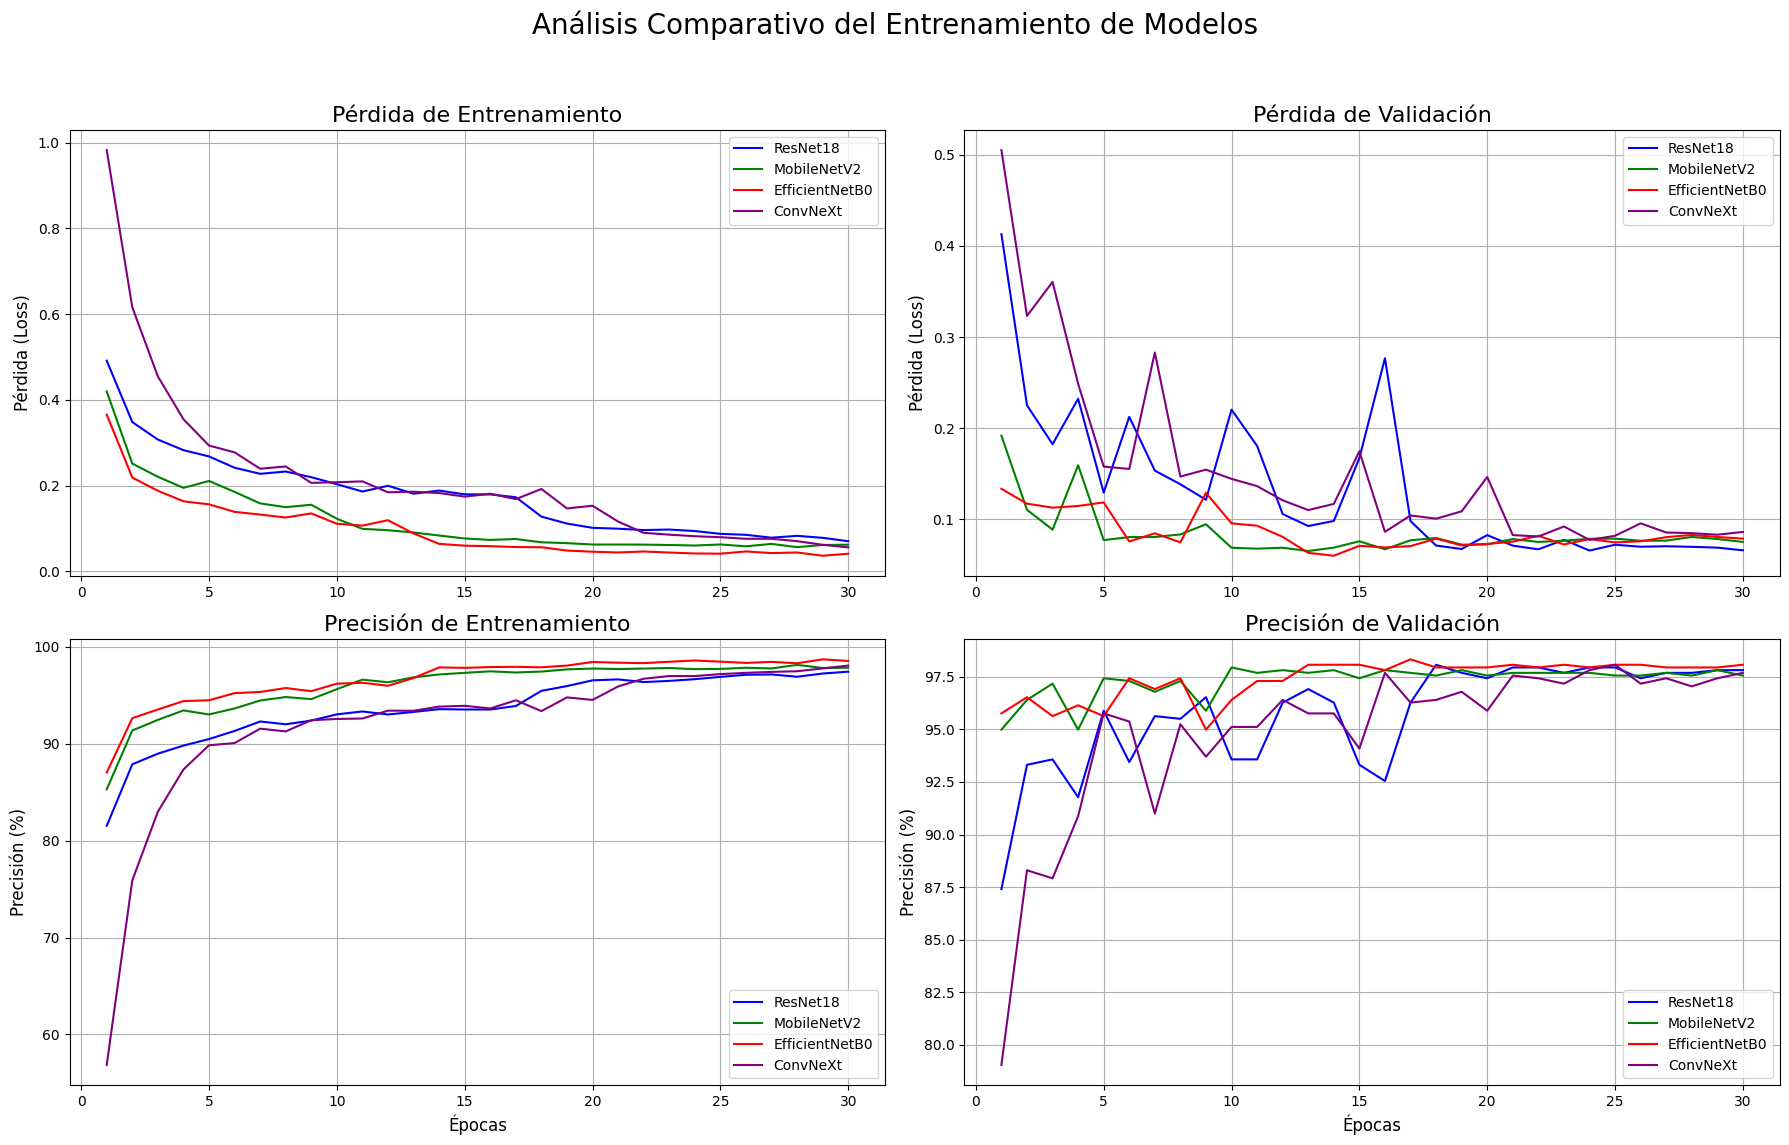

In [7]:
print("\n" + "="*80)
print("GENERANDO GRÁFICAS COMPARATIVAS DEL ENTRENAMIENTO")
print("="*80)

# Diccionario para almacenar los dataframes con los historiales
all_histories_df = {}

# Cargar los datos desde los archivos CSV generados
for model_name in MODELS_TO_TRAIN:
    log_path = os.path.join(RESULTS_DIR, model_name, "training_log.csv")
    if os.path.exists(log_path):
        print(f"Cargando historial para {model_name}...")
        all_histories_df[model_name] = pd.read_csv(log_path)
    else:
        print(f"Advertencia: No se encontró el archivo de log para {model_name}.")

if all_histories_df:
    # Definir colores distintos para cada modelo
    colors = {
        'ResNet18': 'blue',
        'MobileNetV2': 'green',
        'EfficientNetB0': 'red',
        'ConvNeXt': 'purple'
    }

    # Crear una figura con 4 subplots (cuadrícula de 2x2)
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Análisis Comparativo del Entrenamiento de Modelos', fontsize=20)

    # 1. Gráfica de Pérdida de Entrenamiento
    axs[0, 0].set_title('Pérdida de Entrenamiento', fontsize=16)
    for model_name, history_df in all_histories_df.items():
        axs[0, 0].plot(history_df['Epoch'], history_df['Train Loss'], label=model_name, color=colors.get(model_name))
    axs[0, 0].set_ylabel('Pérdida (Loss)', fontsize=12)
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 2. Gráfica de Pérdida de Validación
    axs[0, 1].set_title('Pérdida de Validación', fontsize=16)
    for model_name, history_df in all_histories_df.items():
        axs[0, 1].plot(history_df['Epoch'], history_df['Val Loss'], label=model_name, color=colors.get(model_name))
    axs[0, 1].set_ylabel('Pérdida (Loss)', fontsize=12)
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Gráfica de Precisión de Entrenamiento
    axs[1, 0].set_title('Precisión de Entrenamiento', fontsize=16)
    for model_name, history_df in all_histories_df.items():
        axs[1, 0].plot(history_df['Epoch'], history_df['Train Accuracy'], label=model_name, color=colors.get(model_name))
    axs[1, 0].set_xlabel('Épocas', fontsize=12)
    axs[1, 0].set_ylabel('Precisión (%)', fontsize=12)
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # 4. Gráfica de Precisión de Validación
    axs[1, 1].set_title('Precisión de Validación', fontsize=16)
    for model_name, history_df in all_histories_df.items():
        axs[1, 1].plot(history_df['Epoch'], history_df['Val Accuracy'], label=model_name, color=colors.get(model_name))
    axs[1, 1].set_xlabel('Épocas', fontsize=12)
    axs[1, 1].set_ylabel('Precisión (%)', fontsize=12)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Ajustar el diseño y guardar la figura
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    comparison_plot_path = os.path.join(RESULTS_DIR, "grafica_comparativa_final.png")
    plt.savefig(comparison_plot_path)
    # plt.show() # Puedes descomentar esta línea si quieres ver la gráfica en el notebook

    print(f"\nProceso finalizado. La nueva gráfica ha sido guardada en: '{comparison_plot_path}'.")
    print("Este archivo estará incluido en el .zip final de resultados.")
else:
    print("\nNo se encontraron historiales de entrenamiento para generar la gráfica.")

In [8]:
# ===================================================================
# PASO 6: VALIDACIÓN ESTADÍSTICA
# ===================================================================
print("\n" + "="*80)
print("INICIANDO FASE DE VALIDACIÓN ESTADÍSTICA")
print("="*80)
# --- Paso 1: Obtener las predicciones de cada modelo ---
all_predictions = {}
true_labels = []
print("\nGenerando predicciones para cada modelo...")
# Itera sobre los modelos que realmente terminaron el entrenamiento
models_with_results = [m for m in MODELS_TO_TRAIN if os.path.exists(os.path.join(RESULTS_DIR, m, "best_model.pt"))]

for model_name in models_with_results:
    # Carga la arquitectura del modelo
    if model_name == 'ResNet18': model = resnet18(weights=None); model.fc = nn.Linear(model.fc.in_features, len(class_names))
    elif model_name == 'MobileNetV2': model = mobilenet_v2(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'EfficientNetB0': model = efficientnet_b0(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'ConvNeXt': model = convnext_tiny(weights=None); model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))

    model_path = os.path.join(RESULTS_DIR, model_name, "best_model.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    current_preds = []
    # Solo se obtienen las etiquetas verdaderas la primera vez
    if not true_labels:
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device)); _, predicted = torch.max(outputs, 1)
                current_preds.extend(predicted.cpu().numpy()); true_labels.extend(labels.cpu().numpy())
    else:
        with torch.no_grad():
            for inputs, _ in test_loader:
                outputs = model(inputs.to(device)); _, predicted = torch.max(outputs, 1)
                current_preds.extend(predicted.cpu().numpy())

    all_predictions[model_name] = np.array(current_preds)
    print(f"... Predicciones para {model_name} completadas.")

# --- Paso 2: Preparar los datos para las pruebas ---
correct_predictions_df = pd.DataFrame()
true_labels_np = np.array(true_labels)
for model_name, preds in all_predictions.items():
    correct_predictions_df[model_name] = (preds == true_labels_np).astype(int)

# --- Paso 3: Realizar la Prueba Q de Cochran ---
print("\n" + "-"*80)
print("Realizando la Prueba Q de Cochran para comparar todos los modelos...")
cochran_result = cochrans_q(correct_predictions_df.values)
q_statistic = cochran_result.statistic
p_value_cochran = cochran_result.pvalue

print(f"Estadístico Q de Cochran: {q_statistic:.4f}")
print(f"P-valor: {p_value_cochran:.4f}")

if p_value_cochran < 0.05:
    print("Resultado: El p-valor es significativo (p < 0.05). Existe una diferencia estadística entre los modelos.")
else:
    print("Resultado: El p-valor no es significativo (p >= 0.05). No hay evidencia de que los modelos rindan diferente.")

# --- Paso 4: Realizar Pruebas de McNemar por pares (si es necesario) ---
if p_value_cochran < 0.05:
    print("\n" + "-"*80)
    print("Realizando Pruebas de McNemar por pares para encontrar qué modelos difieren...")
    model_pairs = list(combinations(models_with_results, 2))
    results = []
    for pair in model_pairs:
        model1_name, model2_name = pair
        yes_yes = np.sum((correct_predictions_df[model1_name] == 1) & (correct_predictions_df[model2_name] == 1))
        no_no = np.sum((correct_predictions_df[model1_name] == 0) & (correct_predictions_df[model2_name] == 0))
        yes_no = np.sum((correct_predictions_df[model1_name] == 1) & (correct_predictions_df[model2_name] == 0))
        no_yes = np.sum((correct_predictions_df[model1_name] == 0) & (correct_predictions_df[model2_name] == 1))
        contingency_table = [[yes_yes, yes_no], [no_yes, no_no]]

        mcnemar_result = mcnemar(contingency_table, exact=True)
        results.append({"Modelo 1": model1_name, "Modelo 2": model2_name, "P-valor": mcnemar_result.pvalue})
    results_df = pd.DataFrame(results)
    print(results_df.round(4))
print("\n" + "="*80)
print("VALIDACIÓN ESTADÍSTICA COMPLETADA.")
print("="*80)


INICIANDO FASE DE VALIDACIÓN ESTADÍSTICA

Generando predicciones para cada modelo...
... Predicciones para ResNet18 completadas.
... Predicciones para MobileNetV2 completadas.
... Predicciones para EfficientNetB0 completadas.
... Predicciones para ConvNeXt completadas.

--------------------------------------------------------------------------------
Realizando la Prueba Q de Cochran para comparar todos los modelos...
Estadístico Q de Cochran: 4.5789
P-valor: 0.2054
Resultado: El p-valor no es significativo (p >= 0.05). No hay evidencia de que los modelos rindan diferente.

VALIDACIÓN ESTADÍSTICA COMPLETADA.


In [9]:
# ===================================================================
# PASO 7: ANÁLISIS DE EFICIENCIA (Tiempo de Inferencia)
# ===================================================================
print("\n" + "="*80)
print("INICIANDO ANÁLISIS DE TIEMPO DE INFERENCIA")
print("="*80)

# Usamos una sola imagen del test_loader para la prueba
sample_input, _ = next(iter(test_loader))
sample_input = sample_input.to(device)
inference_times = []

# Itera sobre los modelos que realmente terminaron el entrenamiento
models_with_results = [m for m in MODELS_TO_TRAIN if os.path.exists(os.path.join(RESULTS_DIR, m, "best_model.pt"))]

for model_name in models_with_results:
    # --- LÍNEA CORREGIDA ---
    print(f"\n--- Midiendo inferencia para: {model_name} ---")
    # -------------------------

    # Cargar la arquitectura del modelo
    if model_name == 'ResNet18': model = resnet18(weights=None); model.fc = nn.Linear(model.fc.in_features, len(class_names))
    elif model_name == 'MobileNetV2': model = mobilenet_v2(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'EfficientNetB0': model = efficientnet_b0(weights=None); model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif model_name == 'ConvNeXt': model = convnext_tiny(weights=None); model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))

    # Cargar los pesos del modelo guardado
    model_path = os.path.join(RESULTS_DIR, model_name, "best_model.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Realizar una pasada inicial para "calentar" la GPU/CPU y asegurar mediciones precisas
    with torch.no_grad():
        _ = model(sample_input)

    # Medir el tiempo sobre 100 pasadas para obtener un promedio estable
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(sample_input)
    end_time = time.time()

    # Calcular el tiempo promedio por inferencia en milisegundos
    avg_time_ms = ((end_time - start_time) / 100) * 1000
    inference_times.append({'Modelo': model_name, 'Tiempo de Inferencia (ms)': avg_time_ms})
    print(f"Tiempo promedio: {avg_time_ms:.4f} ms")

# Crear y mostrar una tabla con los resultados ordenados
inference_df = pd.DataFrame(inference_times).sort_values(by='Tiempo de Inferencia (ms)')

print("\n" + "="*80)
print("Tabla Comparativa de Tiempos de Inferencia")
print("="*80)
print(inference_df.round(4))


INICIANDO ANÁLISIS DE TIEMPO DE INFERENCIA

--- Midiendo inferencia para: ResNet18 ---
Tiempo promedio: 21.5118 ms

--- Midiendo inferencia para: MobileNetV2 ---
Tiempo promedio: 25.7250 ms

--- Midiendo inferencia para: EfficientNetB0 ---
Tiempo promedio: 32.8181 ms

--- Midiendo inferencia para: ConvNeXt ---
Tiempo promedio: 179.5054 ms

Tabla Comparativa de Tiempos de Inferencia
           Modelo  Tiempo de Inferencia (ms)
0        ResNet18                    21.5118
1     MobileNetV2                    25.7250
2  EfficientNetB0                    32.8181
3        ConvNeXt                   179.5054


In [10]:
# ===================================================================
# PASO FINAL: EMPAQUETAR LOS RESULTADOS PARA LA DESCARGA
# ===================================================================
# Esta sección se ejecuta al final de todo el proceso.

# Verifica si la carpeta de resultados principal existe
if os.path.exists(RESULTS_DIR):
    print(f"\nComprimiendo la carpeta de resultados completa '{RESULTS_DIR}'...")
    # Usa la librería zipfile de Python para crear el archivo .zip
    with zipfile.ZipFile(FINAL_RESULTS_ZIP_NAME, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Recorre todos los archivos y carpetas dentro del directorio de resultados
        for root, dirs, files in os.walk(RESULTS_DIR):
            for file in files:
                # Escribe cada archivo en el .zip manteniendo la estructura de carpetas
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                                           os.path.join(RESULTS_DIR, '..')))
    # Imprime el mensaje final para el usuario
    print("\n" + "="*50)
    print("¡PROCESO COMPLETADO!")
    print(f"Todos tus resultados (entrenamiento y evaluación) están en el archivo:")
    print(f"===> {FINAL_RESULTS_ZIP_NAME} <===")
    print("Ahora puedes usar la interfaz de Jupyter o el terminal de vast.ai para descargar este único archivo.")
    print("="*50)
else:
    print("ERROR: No se encontró la carpeta de resultados para empaquetar.")


Comprimiendo la carpeta de resultados completa './resultados_clasificacion'...

¡PROCESO COMPLETADO!
Todos tus resultados (entrenamiento y evaluación) están en el archivo:
===> resultados_finales_clasificacion.zip <===
Ahora puedes usar la interfaz de Jupyter o el terminal de vast.ai para descargar este único archivo.
